Milestone 2: Feature Engineering & Baseline Modeling

Week 3

In [7]:
import pandas as pd
import os

# Paths
raw_base = r"C:\msys64\home\Raghav Thaman\internship\data\SUPATLANTIQUE_RAW"
proc_base = r"C:\msys64\home\Raghav Thaman\internship\data\SUPATLANTIQUE_PROC"

# Load labels.csv again
labels_path = os.path.join(raw_base, "labels.csv")
df = pd.read_csv(labels_path)

print("✅ Labels loaded. Total images:", len(df))
df.head()

✅ Labels loaded. Total images: 4568


,file_path,scanner_model,dpi,doc_type
0,C:\msys64\home\Raghav Thaman\internship\data\S...,Canon120-1,150,Officials
1,C:\msys64\home\Raghav Thaman\internship\data\S...,Canon120-1,150,Officials
2,C:\msys64\home\Raghav Thaman\internship\data\S...,Canon120-1,150,Officials
3,C:\msys64\home\Raghav Thaman\internship\data\S...,Canon120-1,150,Officials
4,C:\msys64\home\Raghav Thaman\internship\data\S...,Canon120-1,150,Officials


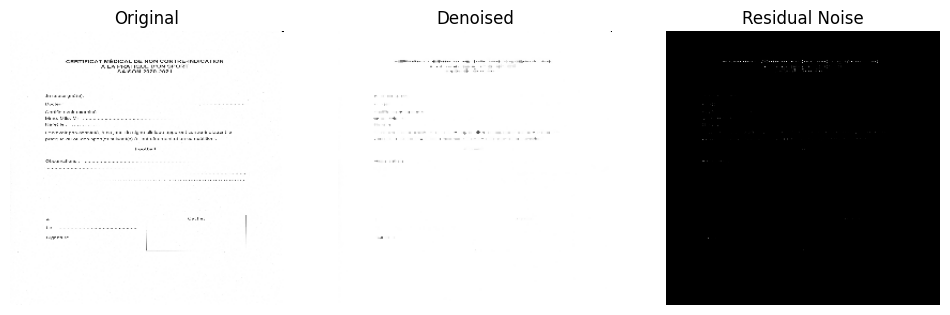

In [8]:
# Week 3
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# Pick one random processed image
row = df.sample(1).iloc[0]
img_path = os.path.join(proc_base, row["doc_type"], row["scanner_model"], str(row["dpi"]), os.path.basename(row["file_path"]))
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Denoise (median blur)
denoised = cv2.medianBlur(img, 3)

# Residual = Original - Denoised
residual = cv2.subtract(img, denoised)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(denoised, cmap="gray"); plt.title("Denoised"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(residual, cmap="gray"); plt.title("Residual Noise"); plt.axis("off")
plt.show()


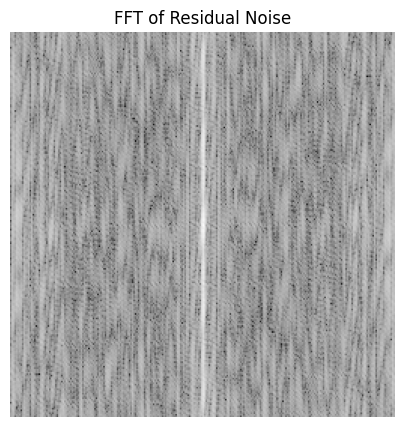

In [9]:
# FFT of residual noise
f = np.fft.fft2(residual)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift)+1)

plt.figure(figsize=(5,5))
plt.imshow(magnitude_spectrum, cmap="gray")
plt.title("FFT of Residual Noise")
plt.axis("off")
plt.show()


In [ ]:
# Define paths for raw and processed flatfield images
flatfield_raw = os.path.join(raw_base, "Flatfield")      # Raw flatfield images
flatfield_proc = os.path.join(proc_base, "Flatfield")    # Destination for processed flatfield images

# Create output directory if it does not exist
os.makedirs(flatfield_proc, exist_ok=True)

# Standard image size for preprocessing
IMG_SIZE = (256, 256)

print("🚀 Preprocessing Flatfield images...")

# Iterate over each scanner model directory inside Flatfield
for scanner_model in os.listdir(flatfield_raw):
    scanner_path = os.path.join(flatfield_raw, scanner_model)

    # Skip if it's not a directory (safety check)
    if not os.path.isdir(scanner_path):
        continue
    
    # Create destination folder for this scanner model
    dest_folder = os.path.join(flatfield_proc, scanner_model)
    os.makedirs(dest_folder, exist_ok=True)
    
    # Process each image file in the scanner directory
    for file_name in os.listdir(scanner_path):
        src_path = os.path.join(scanner_path, file_name)   # Path to raw image
        dest_path = os.path.join(dest_folder, file_name)   # Path for processed image
        
        # Read image in grayscale
        img = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)
        if img is None:   # Skip if file is not a valid image
            continue
        
        # Resize image to standard dimensions
        img_resized = cv2.resize(img, IMG_SIZE)
        
        # Save processed image
        cv2.imwrite(dest_path, img_resized)

print("✅ Flatfield preprocessing complete!")

🚀 Preprocessing Flatfield images...
✅ Flatfield preprocessing complete!


In [11]:
print("Processed Flatfield scanners:", os.listdir(flatfield_proc))

Processed Flatfield scanners: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2', 'EpsonV370-1', 'EpsonV370-2', 'EpsonV39-1', 'EpsonV39-2', 'EpsonV550', 'HP']


In [ ]:
# Extract Flatfield Fingerprints
import numpy as np
import cv2
import os
from tqdm import tqdm

# Path to processed flatfield images
flatfield_base = os.path.join(proc_base, "Flatfield")

# Dictionary to store computed fingerprints for each scanner model
fingerprints = {}

# Iterate through each scanner model folder in Flatfield dataset
for scanner_model in os.listdir(flatfield_base):
    scanner_path = os.path.join(flatfield_base, scanner_model)

    # Skip if not a directory (safety check)
    if not os.path.isdir(scanner_path):
        continue
    
    residuals = []   # List to store residual noise patterns for this scanner
    
    # Process each flatfield image inside this scanner model folder
    for file_name in tqdm(os.listdir(scanner_path), desc=f"Processing {scanner_model}"):
        img_path = os.path.join(scanner_path, file_name)

        # Load image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        
        # Step 1: Apply denoising (median blur) to remove structured content
        denoised = cv2.medianBlur(img, 3)

        # Step 2: Extract residual noise = original - denoised
        residual = cv2.subtract(img, denoised)
        
        # Store residual as float for averaging later
        residuals.append(residual.astype("float32"))
    
    # Step 3: Compute fingerprint for this scanner (mean of residuals)
    if residuals:
        fingerprints[scanner_model] = np.mean(residuals, axis=0)
        print(f"✅ Fingerprint created for {scanner_model}")

# Final summary
print("Total fingerprints created:", len(fingerprints))

Processing Canon120-1:   0%|          | 0/2 [00:00<?, ?it/s]

Processing Canon120-1: 100%|██████████| 2/2 [00:00<00:00, 65.83it/s]


✅ Fingerprint created for Canon120-1


Processing Canon120-2: 100%|██████████| 2/2 [00:00<00:00, 64.55it/s]


✅ Fingerprint created for Canon120-2


Processing Canon220: 100%|██████████| 2/2 [00:00<00:00, 68.43it/s]


✅ Fingerprint created for Canon220


Processing Canon9000-1: 100%|██████████| 2/2 [00:00<00:00, 71.21it/s]


✅ Fingerprint created for Canon9000-1


Processing Canon9000-2: 100%|██████████| 2/2 [00:00<00:00, 58.30it/s]


✅ Fingerprint created for Canon9000-2


Processing EpsonV370-1: 100%|██████████| 2/2 [00:00<00:00, 68.73it/s]


✅ Fingerprint created for EpsonV370-1


Processing EpsonV370-2: 100%|██████████| 2/2 [00:00<00:00, 68.31it/s]


✅ Fingerprint created for EpsonV370-2


Processing EpsonV39-1: 100%|██████████| 2/2 [00:00<00:00, 66.16it/s]


✅ Fingerprint created for EpsonV39-1


Processing EpsonV39-2: 100%|██████████| 2/2 [00:00<00:00, 68.40it/s]


✅ Fingerprint created for EpsonV39-2


Processing EpsonV550: 100%|██████████| 2/2 [00:00<00:00, 63.17it/s]


✅ Fingerprint created for EpsonV550


Processing HP: 100%|██████████| 2/2 [00:00<00:00, 61.40it/s]

✅ Fingerprint created for HP
Total fingerprints created: 11


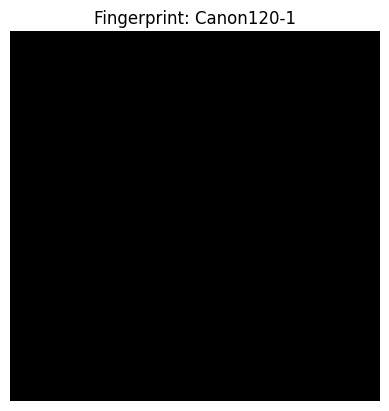

In [13]:
# Visualize one fingerprint
import matplotlib.pyplot as plt

scanner = list(fingerprints.keys())[0]
plt.imshow(fingerprints[scanner], cmap="gray")
plt.title(f"Fingerprint: {scanner}")
plt.axis("off")
plt.show()

In [14]:
# Local Binary Pattern (LBP) Function
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt

# LBP parameters
RADIUS = 3       # radius of the circle
N_POINTS = 8 * RADIUS  # number of sampling points

def extract_lbp_features(image, radius=RADIUS, n_points=N_POINTS):
    # image should be grayscale
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    # Compute histogram of LBP values
    hist, _ = np.histogram(lbp.ravel(),
                           bins=np.arange(0, n_points + 3),
                           range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= hist.sum()  # normalize
    return hist, lbp


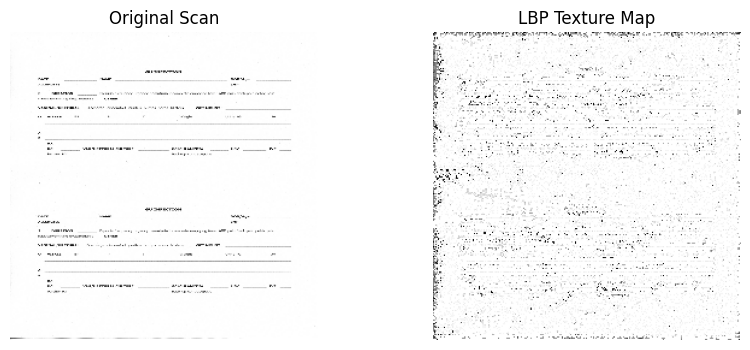

LBP histogram (first 10 bins): [0.00126648 0.00448608 0.0017395  0.00177002 0.00091553 0.00114441
 0.0005188  0.00054932 0.0007782  0.0007782 ]


In [15]:
# Pick one processed Official scan
row = df[df["doc_type"] == "Officials"].sample(1).iloc[0]
sample_path = os.path.join(
    proc_base,
    row["doc_type"],
    row["scanner_model"],
    str(row["dpi"]),
    os.path.basename(row["file_path"])
)

# Load grayscale image
img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)

# Extract LBP
hist, lbp_img = extract_lbp_features(img)

# Show original and LBP image
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.title("Original Scan")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(lbp_img, cmap="gray")
plt.title("LBP Texture Map")
plt.axis("off")
plt.show()

print("LBP histogram (first 10 bins):", hist[:10])


In [ ]:
# Collect LBP Features for All Scanners
import pandas as pd
from tqdm import tqdm

# List to store extracted LBP features
lbp_features = []

# Select a subset of 200 samples from specific document types
subset = df[df["doc_type"].isin(["Officials", "Wikipedia"])].sample(200, random_state=42)

# Iterate through the sampled dataset
for _, row in tqdm(subset.iterrows(), total=len(subset)):
    # Construct full path to the processed image
    sample_path = os.path.join(
        proc_base,
        row["doc_type"],        # Folder by document type
        row["scanner_model"],   # Folder by scanner model
        str(row["dpi"]),        # Folder by DPI
        os.path.basename(row["file_path"])  # Image filename
    )
    
    # Read the image in grayscale
    img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    
    # Extract LBP histogram features from the image
    hist, _ = extract_lbp_features(img)
    
    # Append metadata + extracted features into the list
    lbp_features.append({
        "scanner_model": row["scanner_model"],
        "doc_type": row["doc_type"],
        "dpi": row["dpi"],
        "features": hist
    })

# Convert list of dictionaries to a Pandas DataFrame
lbp_df = pd.DataFrame(lbp_features)

# Display first 5 rows to verify structure
print(lbp_df.head())

100%|██████████| 200/200 [00:12<00:00, 15.90it/s]

  scanner_model   doc_type  dpi  \
0    EpsonV39-1  Officials  300   
1    Canon120-1  Officials  150   
2    Canon120-2  Officials  150   
3      Canon220  Wikipedia  150   
4    EpsonV39-2  Wikipedia  150   

                                            features  
0  [0.0045166015625, 0.0121917724609375, 0.003890...  
1  [0.0, 4.57763671875e-05, 0.0001220703125, 3.05...  
2  [0.000457763671875, 0.000823974609375, 0.00053...  
3  [0.001220703125, 0.00250244140625, 0.000885009...  
4  [0.0010223388671875, 0.00469970703125, 0.00210...  


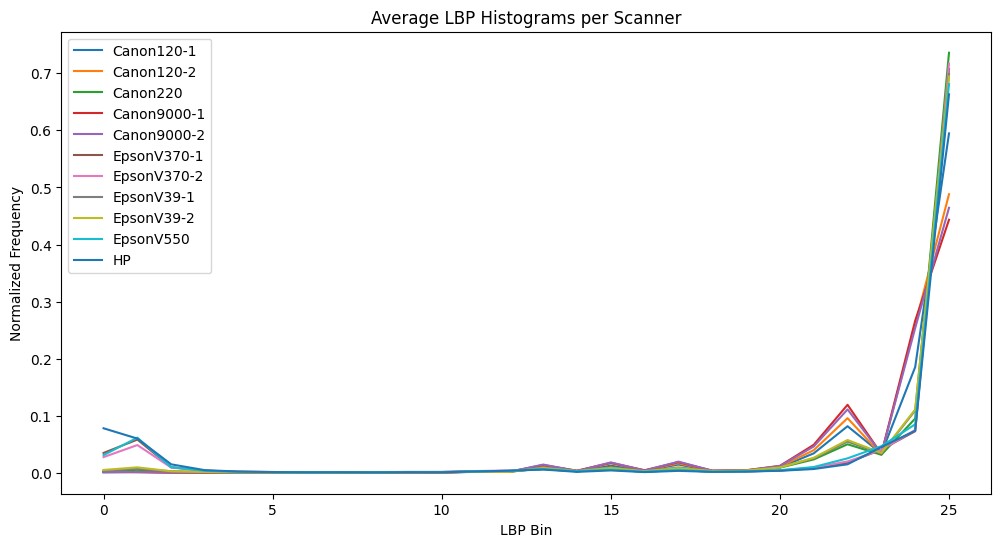

In [ ]:
# Visualize Feature Differences using LBP histograms

# ✅ Step 1: Compute the average LBP histogram for each scanner
scanner_lbps = lbp_df.groupby("scanner_model")["features"].apply(
    lambda x: np.mean(np.vstack(x), axis=0)   # Stack all histograms and compute mean
)

# ✅ Step 2: Plot average histograms
plt.figure(figsize=(12, 6))

# Loop through scanners and plot their average histogram
for scanner, hist in scanner_lbps.items():
    plt.plot(hist, label=scanner)

# Add legend and labels for clarity
plt.legend()
plt.title("Average LBP Histograms per Scanner")
plt.xlabel("LBP Bin")              # Histogram bin index
plt.ylabel("Normalized Frequency") # Feature frequency

# Display the plot
plt.show()

In [18]:
import pandas as pd
import numpy as np

# Flatten features into separate columns
feature_list = []
labels = []

for idx, row in lbp_df.iterrows():
    features = row["features"]  # this is already a histogram array
    feature_list.append(features)
    labels.append(row["scanner_model"])  # or row["doc_type"], depending on what you want to predict

# Create DataFrame
df_features = pd.DataFrame(feature_list)
df_features['label'] = labels

print("Feature matrix shape:", df_features.shape)
print(df_features.head())


Feature matrix shape: (200, 27)
          0         1         2         3         4         5         6  \
0  0.004517  0.012192  0.003891  0.002472  0.001556  0.002014  0.001205   
1  0.000000  0.000046  0.000122  0.000031  0.000061  0.000061  0.000046   
2  0.000458  0.000824  0.000534  0.000458  0.000198  0.000793  0.000885   
3  0.001221  0.002502  0.000885  0.000595  0.000427  0.000610  0.000427   
4  0.001022  0.004700  0.002106  0.000870  0.000580  0.000534  0.000443   

          7         8         9  ...        17        18        19        20  \
0  0.001663  0.001465  0.003723  ...  0.007156  0.001984  0.003250  0.003815   
1  0.000092  0.000229  0.000595  ...  0.030914  0.004425  0.005554  0.014130   
2  0.001663  0.001038  0.003479  ...  0.030640  0.004120  0.005676  0.012482   
3  0.000366  0.000717  0.000977  ...  0.007370  0.004410  0.005112  0.012573   
4  0.000732  0.000885  0.001190  ...  0.015915  0.005310  0.006363  0.012787   

         21        22        23     

In [40]:
df_features.to_csv("week3_features.csv", index=False)
print("Week 3 features saved successfully as week3_features.csv")


Week 3 features saved successfully as week3_features.csv


Week 4

In [19]:
# Week 4
# Convert extracted LBP histograms into X (features) and y (labels)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Features = LBP histograms
X = np.vstack(lbp_df["features"].values)

# Labels = scanner model names
le = LabelEncoder()
y = le.fit_transform(lbp_df["scanner_model"])

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Classes (Scanners):", le.classes_)


X_train shape: (160, 26)
X_test shape: (40, 26)
Classes (Scanners): ['Canon120-1' 'Canon120-2' 'Canon220' 'Canon9000-1' 'Canon9000-2'
 'EpsonV370-1' 'EpsonV370-2' 'EpsonV39-1' 'EpsonV39-2' 'EpsonV550' 'HP']


Logistic Regression Accuracy: 0.225


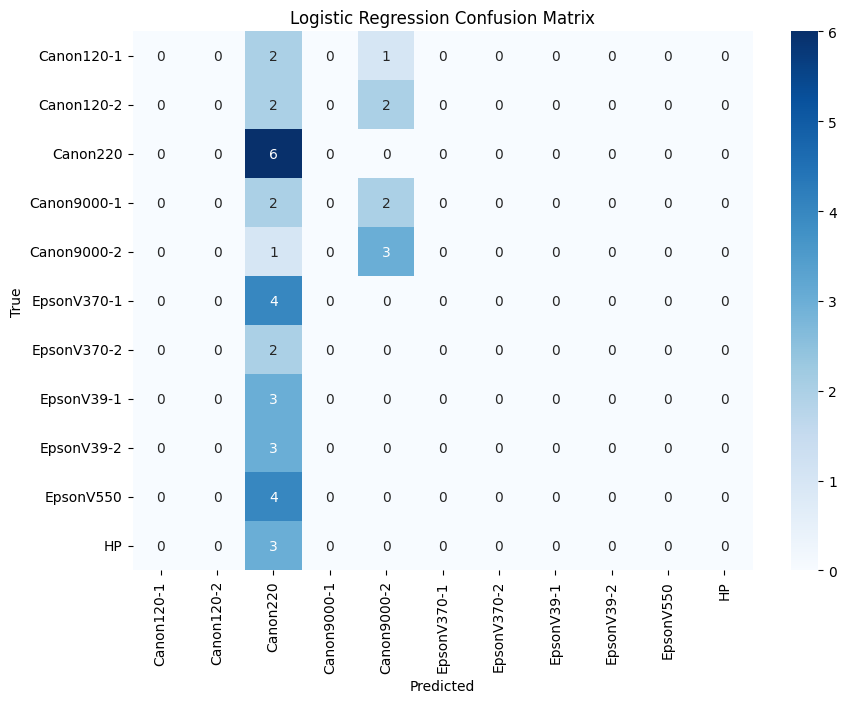

In [ ]:
# Train Logistic Regression and evaluate performance

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train logistic regression
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", acc)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

SVM Accuracy: 0.225


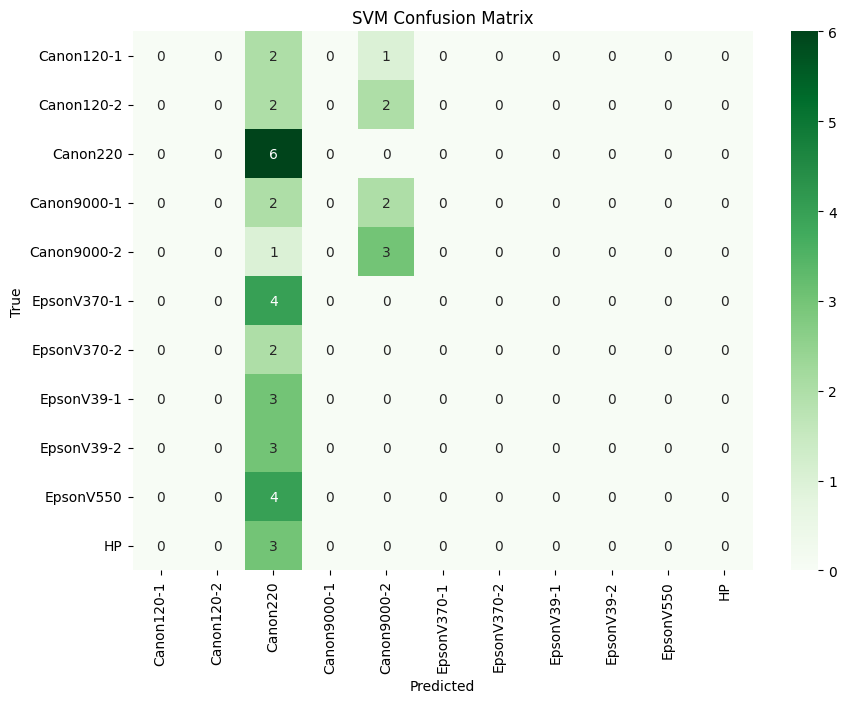

In [ ]:
# ---------------------------------------------------------------
# Train Logistic Regression and evaluate performance
# ---------------------------------------------------------------

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------------------
# Step 1: Initialize Logistic Regression model
# - max_iter=500 ensures the optimizer runs enough iterations 
#   to converge for larger feature sets.
# ---------------------------------------------------------------
log_reg = LogisticRegression(max_iter=500)

# ---------------------------------------------------------------
# Step 2: Train the model on training data
# - X_train: feature matrix for training
# - y_train: true labels for training
# ---------------------------------------------------------------
log_reg.fit(X_train, y_train)

# ---------------------------------------------------------------
# Step 3: Predict labels on test set
# - X_test: feature matrix for testing
# - y_pred: predicted labels from the trained model
# ---------------------------------------------------------------
y_pred = log_reg.predict(X_test)

# ---------------------------------------------------------------
# Step 4: Evaluate model performance using accuracy
# - accuracy_score compares predicted vs actual labels
# ---------------------------------------------------------------
acc = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", acc)

# ---------------------------------------------------------------
# Step 5: Build Confusion Matrix
# - Shows where predictions match (diagonal) vs misclassified
# - Useful for understanding class-specific errors
# ---------------------------------------------------------------
cm = confusion_matrix(y_test, y_pred)

# ---------------------------------------------------------------
# Step 6: Visualize the Confusion Matrix
# - Annotated heatmap using seaborn
# - xticklabels, yticklabels: class names from label encoder
# ---------------------------------------------------------------
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=le.classes_, 
            yticklabels=le.classes_, 
            cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

Random Forest Accuracy: 0.475


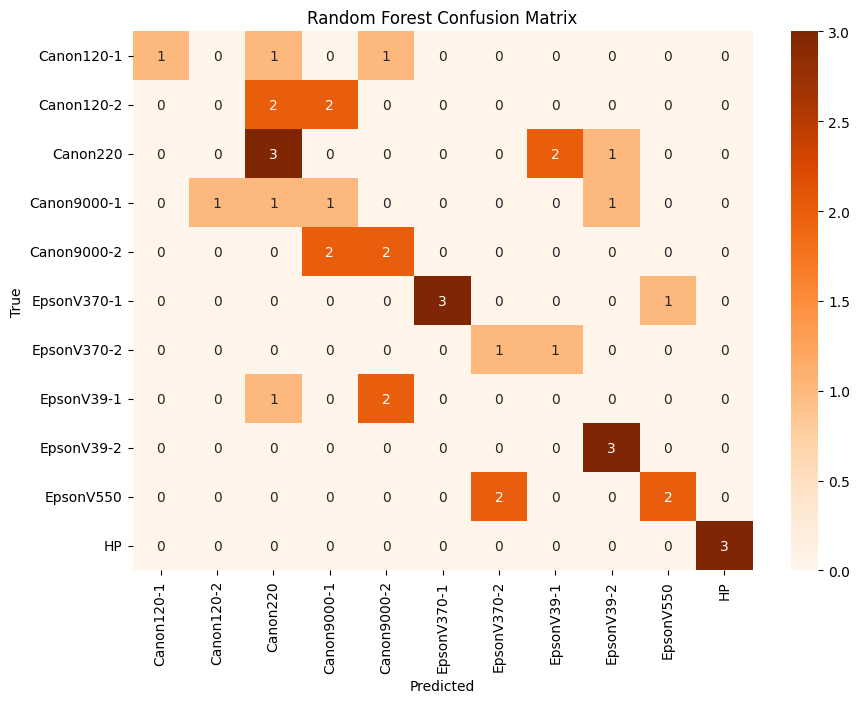

In [ ]:
# ---------------------------------------------------------------
# Train Random Forest and evaluate performance
# ---------------------------------------------------------------

from sklearn.ensemble import RandomForestClassifier

# ---------------------------------------------------------------
# Step 1: Initialize Random Forest Classifier
# - n_estimators=100 → build 100 decision trees
# - random_state=42 → ensures reproducibility
# ---------------------------------------------------------------
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# ---------------------------------------------------------------
# Step 2: Train the Random Forest on training data
# - X_train: feature matrix for training
# - y_train: true labels for training
# ---------------------------------------------------------------
rf.fit(X_train, y_train)

# ---------------------------------------------------------------
# Step 3: Predict labels on test set
# - X_test: feature matrix for testing
# - y_pred: predicted labels from the trained RF model
# ---------------------------------------------------------------
y_pred = rf.predict(X_test)

# ---------------------------------------------------------------
# Step 4: Evaluate model performance using accuracy
# - accuracy_score compares predicted vs actual labels
# ---------------------------------------------------------------
acc = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy:", acc)

# ---------------------------------------------------------------
# Step 5: Build Confusion Matrix
# - Shows correctly vs incorrectly classified samples
# - Diagonal → correct predictions, Off-diagonal → errors
# ---------------------------------------------------------------
cm = confusion_matrix(y_test, y_pred)

# ---------------------------------------------------------------
# Step 6: Visualize the Confusion Matrix
# - Heatmap representation for easier interpretation
# - xticklabels & yticklabels → class labels (decoded from le)
# ---------------------------------------------------------------
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=le.classes_, 
            yticklabels=le.classes_, 
            cmap="Oranges")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Confusion Matrix")
plt.show()

In [23]:
# Compare accuracy of all three models

results = {}

# Logistic Regression
results["Logistic Regression"] = accuracy_score(y_test, log_reg.predict(X_test))

# SVM
results["SVM"] = accuracy_score(y_test, svm.predict(X_test))

# Random Forest
results["Random Forest"] = accuracy_score(y_test, rf.predict(X_test))

print("📊 Model Comparison:", results)


📊 Model Comparison: {'Logistic Regression': 0.225, 'SVM': 0.225, 'Random Forest': 0.475}


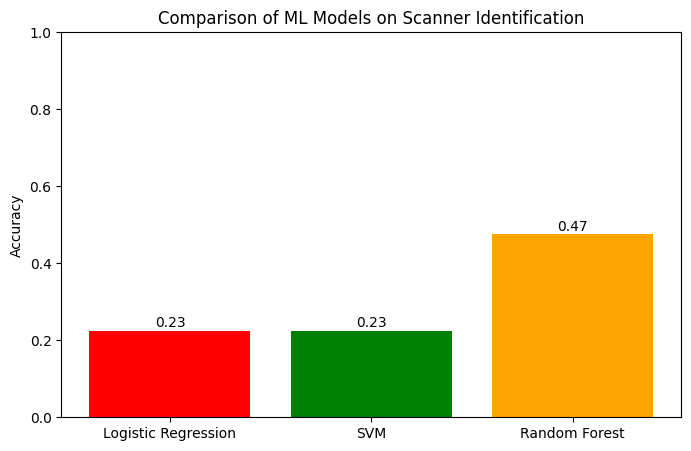

In [ ]:
# Bar graph plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Recreate results dictionary
results = {
    "Logistic Regression": accuracy_score(y_test, log_reg.predict(X_test)),
    "SVM": accuracy_score(y_test, svm.predict(X_test)),
    "Random Forest": accuracy_score(y_test, rf.predict(X_test))
}

# Bar plot
plt.figure(figsize=(8,5))
plt.bar(results.keys(), results.values(), color=["red", "green", "orange"])
plt.ylabel("Accuracy")
plt.ylim(0,1)  # accuracy between 0 and 1
plt.title("Comparison of ML Models on Scanner Identification")

# Add accuracy values on top of bars
for i, (model, acc) in enumerate(results.items()):
    plt.text(i, acc+0.01, f"{acc:.2f}", ha="center")

plt.show()


In [ ]:
# Record Results in a Table
import pandas as pd

results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
print(results_df)

                 Model  Accuracy
0  Logistic Regression     0.225
1                  SVM     0.225
2        Random Forest     0.475


In [30]:
print("Logistic Regression performed the weakest, showing limited ability to separate scanner-specific textures.\n"

"SVM improved classification but requires kernel tuning for best results.\n"

"Random Forest performed the best, handling non-linear feature patterns.\n"

"Limitation: All models depend on hand-crafted features (LBP, FFT, residual noise). These features may not capture subtle scanner-specific artifacts.\n"

"Next Step: Deep learning (CNNs) can automatically learn more powerful representations from raw images.")

Logistic Regression performed the weakest, showing limited ability to separate scanner-specific textures.
SVM improved classification but requires kernel tuning for best results.
Random Forest performed the best, handling non-linear feature patterns.
Limitation: All models depend on hand-crafted features (LBP, FFT, residual noise). These features may not capture subtle scanner-specific artifacts.
Next Step: Deep learning (CNNs) can automatically learn more powerful representations from raw images.
